# Project_9_Twitter US Airline Sentiment

# Background and Context

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad
population and connect with customers without intermediaries. On the other hand, there’s so
much information that it’s difficult for brands to quickly detect negative social mentions that
could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in
conversations on social media platforms, has become a key strategy in social media marketing.

Listening to how customers feel about the product/service on Twitter allows companies to
understand their audience, keep on top of what’s being said about their brand and their
competitors, and discover new trends in the industry.

# Data Description

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was
scraped from February of 2015 and contributors were asked to first classify positive, negative,
and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude
service").

# Dataset

The dataset has the following columns:
    
1. tweet_id
2. airline_sentiment
3. airline_sentiment_confidence
4. negativereason
5. negativereason_confidence
6. airline
7. airline_sentiment_gold
8. name
9. negativereason_gold
10. retweet_count
11. text
12. tweet_coord
13. tweet_created
14. tweet_location
15. user_timezone

# Import the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re, string, unicodedata
from bs4 import BeautifulSoup

!pip install contractions
import nltk
import contractions

nltk.download('wordnet')
nltk.download('punkt')

from nltk.tokenize import word_tokenize 
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix

from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
tweet_data = pd.read_csv("Tweets.csv")

In [3]:
tweet_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Shape of data

In [4]:
print(tweet_data.shape)

(14640, 15)


In [5]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

# Checking if data is duplicated and removing duplicates

In [6]:
# Check for duplicate rows
duplicatekobe = tweet_data[tweet_data.duplicated()]
print(duplicatekobe.head())
print(duplicatekobe.shape)  
# There are 36 duplicate rows

                 tweet_id airline_sentiment  airline_sentiment_confidence  \
12040  570308309682675712          negative                           1.0   
12059  570305051819941889           neutral                           1.0   
12063  570303383782989824           neutral                           1.0   
12066  570301929580048385           neutral                           1.0   
12068  570301395141836801          negative                           1.0   

               negativereason  negativereason_confidence   airline  \
12040  Customer Service Issue                        1.0  American   
12059                     NaN                        NaN  American   
12063                     NaN                        NaN  American   
12066                     NaN                        NaN  American   
12068             Late Flight                        1.0  American   

      airline_sentiment_gold            name negativereason_gold  \
12040                    NaN      SweeLoTmac    

In [7]:
# Drop the duplicate rows
tweet_data.drop_duplicates(keep=False,inplace=True) 

In [8]:
print(tweet_data.shape)

(14568, 15)


In [9]:
tweet_data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.456800e+04,14568.000000,10484.000000,14568.000000
mean,5.692131e+17,0.899675,0.636987,0.082921
std,7.773880e+14,0.163080,0.330318,0.747520
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685551e+17,0.691975,0.360300,0.000000
50%,5.694655e+17,1.000000,0.670400,0.000000
75%,5.698859e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


# Exploratory data Analysis EDA

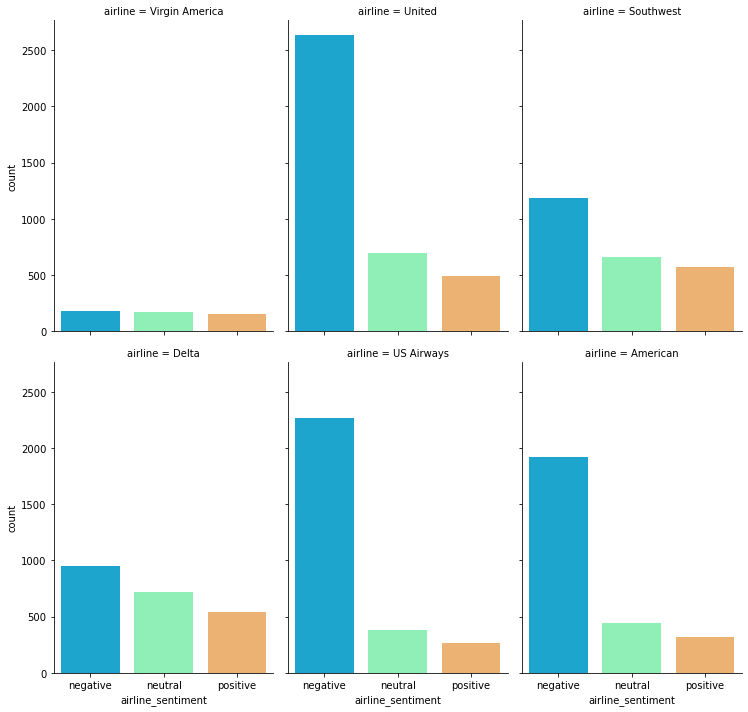

In [10]:
g = sns.FacetGrid(tweet_data, col="airline", col_wrap=3, height=5, aspect =0.7)
g = g.map(sns.countplot, "airline_sentiment",order =tweet_data.airline_sentiment.value_counts().index, palette='rainbow')
plt.show()

In [11]:
#Number of sentiments in each category

tweet_data.airline_sentiment.value_counts()

negative    9140
neutral     3083
positive    2345
Name: airline_sentiment, dtype: int64

C:\Users\Owner\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


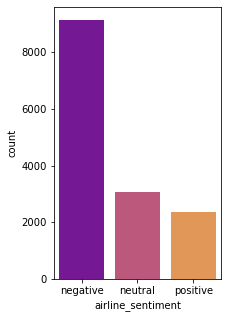

In [12]:
plt.figure(figsize=(3,5))
sns.countplot(tweet_data['airline_sentiment'], order =tweet_data.airline_sentiment.value_counts().index,palette= 'plasma')
plt.show()

Customer Service Issue         2898
Late Flight                    1655
Can't Tell                     1190
Cancelled Flight                839
Lost Luggage                    718
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     479
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


C:\Users\Owner\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


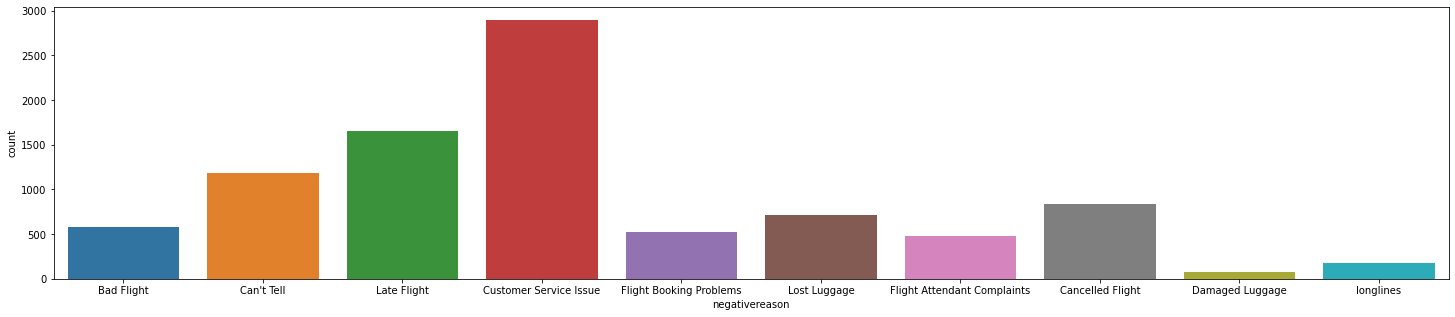

In [13]:
# Check the most common negative reason 
y = tweet_data['negativereason']
print(y.value_counts())
plt.figure(figsize=(25,5)) 
g = sns.countplot(y)

In [14]:
Negative Reasons in descending order

SyntaxError: invalid syntax (2888742371.py, line 1)

C:\Users\Owner\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


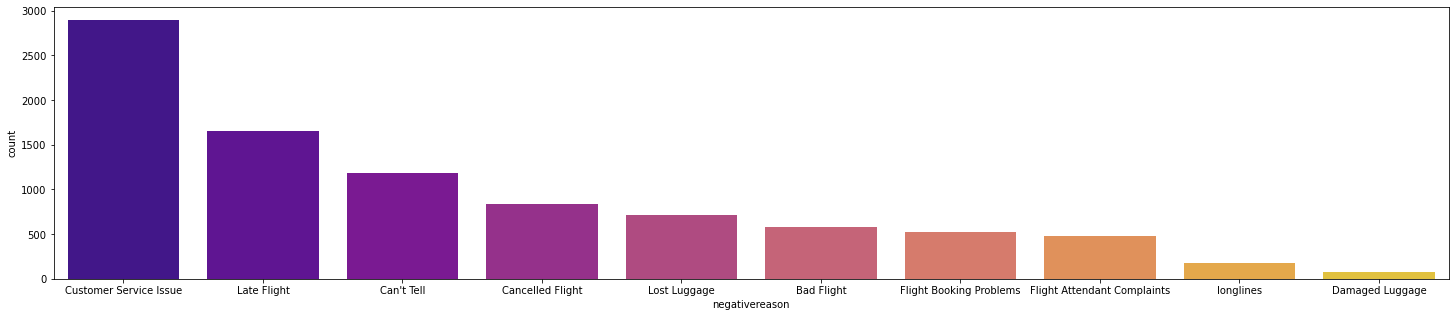

In [15]:
plt.figure(figsize=(25,5)) 
sns.countplot(y, order =y.value_counts().index,palette= 'plasma')
plt.show()

In [16]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.title("Relation between " + predictor + " vs. " + target)
    plt.show()

airline_sentiment  negative  neutral  positive    All
airline                                              
All                    9140     3083      2345  14568
Southwest              1186      664       570   2420
Delta                   955      723       544   2222
United                 2633      697       492   3822
American               1922      447       318   2687
US Airways             2263      381       269   2913
Virgin America          181      171       152    504
------------------------------------------------------------------------------------------------------------------------


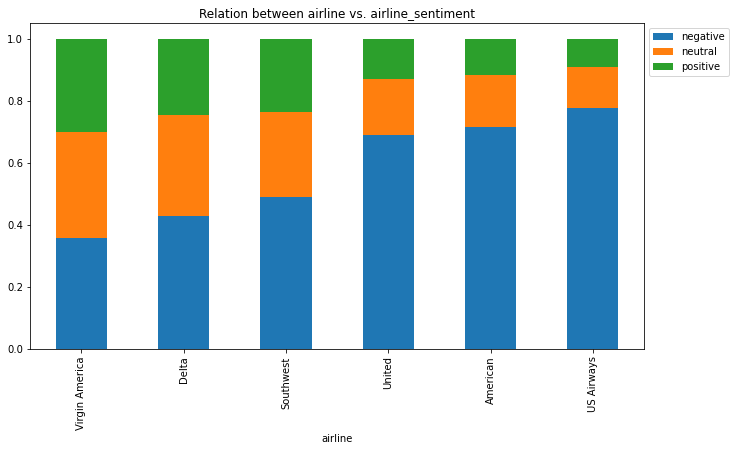

In [17]:
stacked_barplot(tweet_data, "airline", "airline_sentiment")

# Drawing a Pie Chart to give a different view 

In [18]:
plot_size = plt.rcParams['figure.figsize']

print(plot_size[0])

print(plot_size[1])

plot_size[0] = 10

plot_size[1] = 8

plt.rcParams['figure.figsize'] = plot_size

6.0
4.0


<AxesSubplot:ylabel='airline_sentiment'>

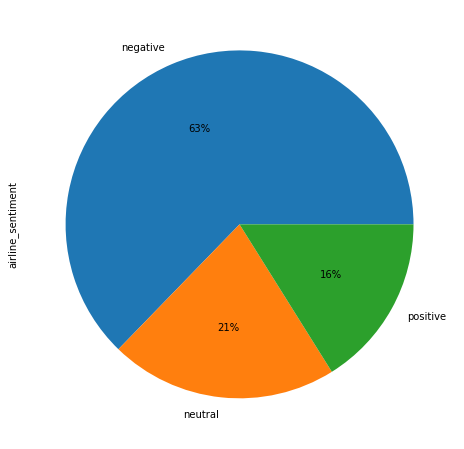

In [19]:
tweet_data.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')

# Observation

1. The dataset contains are 14668 rows and 15 columns.
2. 36 duplicate records in the data set were removed.
3. Negative sentiment was about 63 % of total sentiments in the dataset follwed by neutral at 21% and positive at 16%
4. United Airlines has the most negative tweets at 2633, follwed by US Airways at 2263 and then American at 1922
5. Customer service and Late flight seems to be the main reason why customers.
6. Most of tweets on US Airways were negative whiles most of the tweets on Virgin Atlantic were about evenly distributed   between positive, netral and negative.

We will now review the columns to see which one are relevant and which are not. Irrelevant ones will be dropped on this exercise.

In [21]:
tweet_data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

Drop Irrelevant columns

In [22]:
tweet2 = tweet_data.drop(['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count','tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], axis =1)

In [23]:
tweet2.shape

(14568, 2)

In [24]:
tweet2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14568 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14568 non-null  object
 1   text               14568 non-null  object
dtypes: object(2)
memory usage: 341.4+ KB


In [25]:
tweet2.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


We know that data is imbalanced

negative    9140
neutral     3083
positive    2345
Name: airline_sentiment, dtype: int64


C:\Users\Owner\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


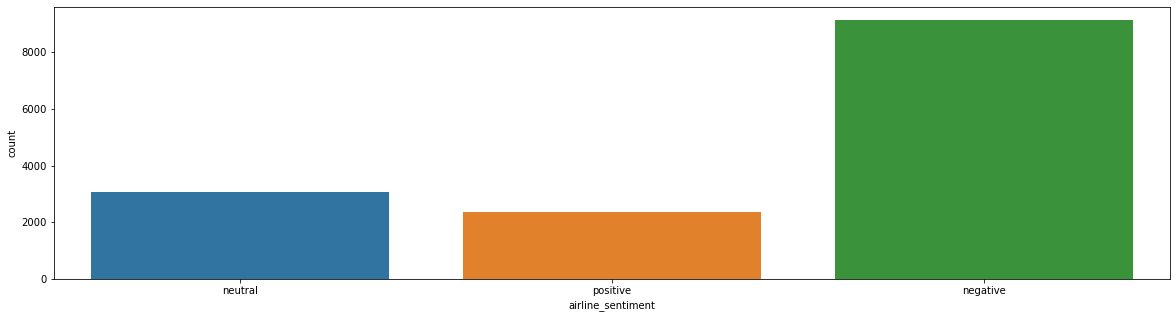

In [26]:
y = tweet2['airline_sentiment']
print(y.value_counts())
plt.figure(figsize=(20,5)) 
g = sns.countplot(y)

We see that negative sentiments are dispropotionately high and we will treat by SMOTE before modelling

# Text pre-processing

    a. Html tag removal.
    b. Tokenization.
    c. Remove the numbers.
    d. Removal of Special Characters and Punctuations.
    e. Conversion to lowercase.
    f. Lemmatize or stemming.
    g. Join the words in the list to convert back to text string in the dataframe. (So that each row contains the data in text format.) 

In [27]:
#Html tag removal
def perform_html_cleanup( raw_review ):
  # 1. Remove HTML
  review_text = BeautifulSoup(raw_review).get_text()
  return review_text

#Replace Contraction
def replace_contractions(raw_review):
    #Replace contractions in raw_review
    return contractions.fix(raw_review)

#Tokenization
def perform_tokenization( raw_review ):
   word_tokens = word_tokenize(raw_review)  # Tokenization
   return word_tokens

#Removal of Numbers
def remove_numbers(list_of_words): 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list_of_words] 
    return list

#Remove special characters
def remove_special_character_punctuation(list_of_words): 
    pattern = '[^A-Za-z0-9]+'
    list = [re.sub(pattern, '', i) for i in list_of_words] 
    return list

#Remove punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words


#Conversion to Lower case
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words



#Remove empty String
def remove_empty_string(words):
  return list(filter(None, words))


#Stemming
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []                            # Create empty list to store pre-processed words.
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)                # Append processed words to new list.
    return stems


#Lemmatization
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           # Create empty list to store pre-processed words.
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)              # Append processed words to new list.
    return lemmas


Complete Pre-preocessing

In [28]:
def perform_cleanup(raw_review):
    clean_review = perform_html_cleanup(raw_review)
    clean_review = replace_contractions(clean_review)
    clean_review = perform_tokenization(clean_review)
    clean_review = remove_numbers(clean_review)
    clean_review = remove_special_character_punctuation(clean_review)
    clean_review = remove_punctuation(clean_review)
    clean_review  = to_lowercase(clean_review)
    clean_review = remove_empty_string(clean_review)
    #clean_review = stem_words(clean_review)
    clean_review = lemmatize_verbs(clean_review)
    return clean_review

In [29]:
print(tweet2.head())

  airline_sentiment                                               text
0           neutral                @VirginAmerica What @dhepburn said.
1          positive  @VirginAmerica plus you've added commercials t...
2           neutral  @VirginAmerica I didn't today... Must mean I n...
3          negative  @VirginAmerica it's really aggressive to blast...
4          negative  @VirginAmerica and it's a really big bad thing...


Join the words in the list to convert back to text string in the dataframe

In [30]:
clean_reviews = []

for i, row in tweet2.iterrows():
    words = tweet2.at[i, 'text']
    words = perform_cleanup(words)
    tweet2.at[i,'text'] = " ".join( words )
    clean_reviews.append( tweet2.at[i, 'text'] )
tweet2.head()

C:\Users\Owner\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus you have add commercials to...
2,neutral,virginamerica i do not today must mean i need ...
3,negative,virginamerica it be really aggressive to blast...
4,negative,virginamerica and it be a really big bad thing...


Print first 5 rows of data after pre-processing

In [31]:
tweet2.head(10)

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus you have add commercials to...
2,neutral,virginamerica i do not today must mean i need ...
3,negative,virginamerica it be really aggressive to blast...
4,negative,virginamerica and it be a really big bad thing...
5,negative,virginamerica seriously would pay a flight for...
6,positive,virginamerica yes nearly every time i fly vx t...
7,neutral,virginamerica really miss a prime opportunity ...
8,positive,virginamerica well i do notbut now i do d
9,positive,virginamerica it be amaze and arrive an hour e...


# Vectorization

# TfidfVectorizer


In [32]:
# Initialize the "TfidfVectorizer" object
# Convert a collection of raw documents to a matrix of TF-IDF features.
tfidf_vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000,
                             min_df=5, 
                             max_df=0.7,
                             ngram_range=(1,2)) 

# Fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
tfidf_vectorizer_data_features = tfidf_vectorizer.fit_transform(clean_reviews)

# Convert to Numpy arrays

tfidf_vectorizer_data_features = tfidf_vectorizer_data_features.toarray()

In [33]:
print (tfidf_vectorizer_data_features.shape)
print(tfidf_vectorizer_data_features)

(14568, 5000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
#Review words
tfidf_vectorizer_vocab = tfidf_vectorizer.get_feature_names()
print (tfidf_vectorizer_vocab)

['aa', 'aa be', 'aadvantage', 'able', 'able to', 'about', 'about an', 'about it', 'about my', 'about our', 'about the', 'about this', 'about to', 'about you', 'about your', 'above', 'absolute', 'absolutely', 'absurd', 'ac', 'accept', 'acceptable', 'access', 'access to', 'accommodate', 'accord', 'accord to', 'account', 'accurate', 'across', 'act', 'action', 'actual', 'actually', 'add', 'add my', 'add to', 'additional', 'address', 'admirals', 'admirals club', 'advance', 'advantage', 'advertise', 'advice', 'advise', 'advisory', 'affect', 'afford', 'after', 'after an', 'after be', 'after hours', 'after land', 'after my', 'after the', 'after wait', 'afternoon', 'again', 'again for', 'again you', 'age', 'agent', 'agent at', 'agent be', 'agents', 'agents at', 'agents be', 'ago', 'ago and', 'ago be', 'ah', 'ahead', 'air', 'aircraft', 'airfare', 'airline', 'airline be', 'airline ever', 'airline have', 'airline in', 'airline that', 'airline to', 'airlines', 'airlines be', 'airplane', 'airport', 

C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Stop Words

In [35]:
tfidf_vectorizer_stop_words = tfidf_vectorizer.get_stop_words()
print (tfidf_vectorizer_stop_words)

None


Sum up the counts of each vocabulary word

In [36]:
# Sum up the counts of each vocabulary word
tf_df_dist = np.sum(tfidf_vectorizer_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(tfidf_vectorizer_vocab, tf_df_dist):
    print (count, tag)

52.724441321484505 aa
3.446130661198859 aa be
2.8916383358537825 aadvantage
24.030209350516788 able
22.30831568247479 able to
86.91646159407996 about
3.4288613654905347 about an
7.371792721538559 about it
10.9319098769699 about my
3.0774386090414834 about our
14.819627058389196 about the
4.434602336262759 about this
6.197864809713441 about to
4.347572796818376 about you
5.753403920688679 about your
5.296781844539412 above
6.833150030347803 absolute
9.944184187994313 absolutely
3.7628171755097997 absurd
2.5825421372281996 ac
9.424758829819098 accept
6.317689837724596 acceptable
10.669049874502814 access
5.663949020633231 access to
7.196811310948114 accommodate
3.2455787191965264 accord
3.2455787191965264 accord to
20.746389662366074 account
2.984627288531152 accurate
4.734170664733707 across
5.420868409305928 act
4.123767242276361 action
5.7009588486251035 actual
20.378019704009066 actually
29.32536894753799 add
4.653959711623271 add my
3.9446696950250986 add to
4.735887745630221 additi

5.249292746077063 limit
39.59734710469608 line
3.033076030418836 line and
3.1765816486490617 line at
4.974211327360209 line be
4.75645044618877 line for
18.991611193100262 link
3.7270865992745503 link to
11.817240793888885 list
8.800530457685825 listen
5.299976488538387 listen to
8.295466579100054 literally
16.921799705774646 little
14.219315450547649 live
4.6360776114837785 live in
2.715578067444733 live person
12.90629629005842 load
2.7523105897201936 local
6.3642795342554015 locate
4.585125451802926 locator
5.024605706286525 log
3.885291623338109 logan
17.291292561385635 lol
4.256855361189098 london
36.72090645735701 long
2.8300280043354413 long day
3.3501459176010044 long do
3.552533037626948 long time
4.409411385416751 long wait
14.31270192129946 longer
3.049388061126137 longer than
57.103446971215874 look
8.817578439355422 look at
11.44137234716356 look for
10.339562049356207 look forward
6.087798478668153 look into
16.692914249187034 look like
3.853217608056642 look to
58.307256

6.360929487371395 useless
3.959694260704189 usual
5.638414109307813 usually
3.2415563632823754 va
17.72675856372472 vacation
2.635456141638824 valid
4.968946320398003 value
21.368108478714728 vegas
2.840628300953922 vegas to
53.34604839039546 very
5.80043118456003 very disappoint
5.835790261252272 very frustrate
5.159680938692359 very helpful
6.464203555002885 very much
26.156486329053195 via
3.314857946051837 via dm
2.782014359423689 via phone
2.8956741591721147 via twitter
6.3687080646476915 video
9.01733164898039 view
9.40695947663033 virgin
113.1785748292651 virginamerica
11.970649006911179 virginamerica be
4.150513268410897 virginamerica can
4.5721391170881605 virginamerica do
5.509978098715158 virginamerica have
3.6129941166023283 virginamerica ladygaga
3.8075892584386657 virginamerica love
10.944110887592483 virginamerica thank
3.56804912107382 virginamerica what
3.476101091571892 virginamerica why
8.335108189195116 virginamerica you
4.063434733997126 virginamerica your
3.155159

# Model Fitting

# Random Forest Classifier on TfidfVectorizer

In [37]:
x_tf_idf = tfidf_vectorizer_data_features     # Predictor feature columns
y_tf_idf = tweet2['airline_sentiment']   # Predicted class

x_train_tf_idf, x_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(x_tf_idf, y_tf_idf, test_size=0.3, random_state=1)

In [38]:
print(x_train_tf_idf.shape)
print(y_train_tf_idf.shape)
print(x_test_tf_idf.shape)
print(y_test_tf_idf.shape)

(10197, 5000)
(10197,)
(4371, 5000)
(4371,)


negative    9140
neutral     3083
positive    2345
Name: airline_sentiment, dtype: int64


C:\Users\Owner\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


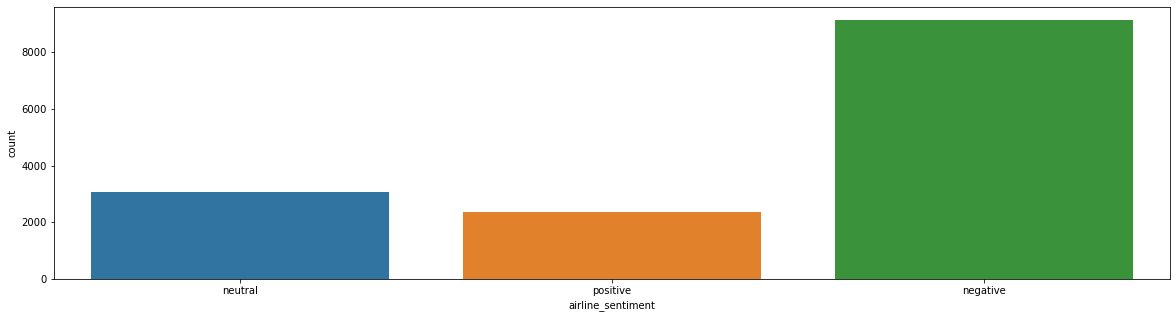

In [39]:
y = tweet2['airline_sentiment']
print(y.value_counts())
plt.figure(figsize=(20,5)) 
g = sns.countplot(y)
# No, Here we can see that the data is not balanced, There are lot of negative sentiments

# Applying SMOTE since the data is not balanced

In [40]:
smt = SMOTE(random_state=0)

In [41]:
tf_idf_smt = SMOTE(random_state=0)
X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE = smt.fit_resample(x_train_tf_idf, y_train_tf_idf)

In [42]:
print(X_train_tf_idf_SMOTE.shape)
print(y_train_tf_idf_SMOTE.shape)

(19266, 5000)
(19266,)


negative    6422
positive    6422
neutral     6422
Name: airline_sentiment, dtype: int64


C:\Users\Owner\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


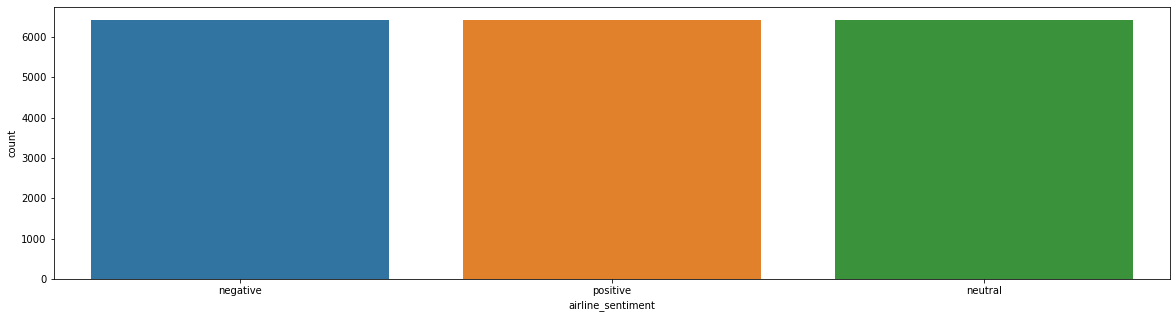

In [43]:
after_smote_airline_sentiment_tf_idf=pd.DataFrame(y_train_tf_idf_SMOTE, columns=['airline_sentiment']) 
y = after_smote_airline_sentiment_tf_idf['airline_sentiment']
print(y.value_counts())
plt.figure(figsize=(20,5))
g = sns.countplot(y)


We can see that the data for modelling is now balanced

In [44]:
# Dividing the test data into test and validation set in 50-50 ratio
x_validation_tf_idf, x_test_main_tf_idf, y_validation_tf_idf, y_test_main_tf_idf = train_test_split(x_test_tf_idf, y_test_tf_idf, test_size=0.50, random_state=1)

print(x_validation_tf_idf.shape)
print(x_test_main_tf_idf.shape)


print(y_validation_tf_idf.shape)
print(y_test_main_tf_idf.shape)



(2185, 5000)
(2186, 5000)
(2185,)
(2186,)


# Initialize RandomForestClassifier

In [45]:
# Initialize a Random Forest classifier with 100 trees
randomforestclassifier_tf_idf = RandomForestClassifier(verbose=1,n_jobs=-1,n_estimators = 100) 
# Fit the forest to the training set

print ("Training the random forest...")
randomforestclassifier_tf_idf = randomforestclassifier_tf_idf.fit( X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE)

Training the random forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.1s finished


In [46]:
#
randomforestclassifier_tf_idf.score(X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


0.9977161839510018

# Evaluate score by cross-validation


In [47]:
print (np.mean(cross_val_score(randomforestclassifier_tf_idf,X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE,cv=10)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]:

0.9116668310250413


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [48]:
# Make class predictions for the Validation set
y_validation_predict_tf_idf= randomforestclassifier_tf_idf.predict(x_validation_tf_idf)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


# Training and Validation Accuracy

In [49]:
print("Trainig accuracy",randomforestclassifier_tf_idf.score(X_train_tf_idf_SMOTE,y_train_tf_idf_SMOTE))  
print()
print("Validation accuracy",randomforestclassifier_tf_idf.score(x_validation_tf_idf, y_validation_tf_idf))
print()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Trainig accuracy 0.9977161839510018

Validation accuracy 0.7794050343249428



# Classification Report (Validation Set)

In [50]:
print(metrics.classification_report(y_validation_tf_idf,y_validation_predict_tf_idf))

              precision    recall  f1-score   support

    negative       0.81      0.92      0.86      1331
     neutral       0.64      0.51      0.57       467
    positive       0.80      0.62      0.70       387

    accuracy                           0.78      2185
   macro avg       0.75      0.68      0.71      2185
weighted avg       0.77      0.78      0.77      2185



# Confusion Matrix (Validation Set)

<Figure size 720x576 with 0 Axes>

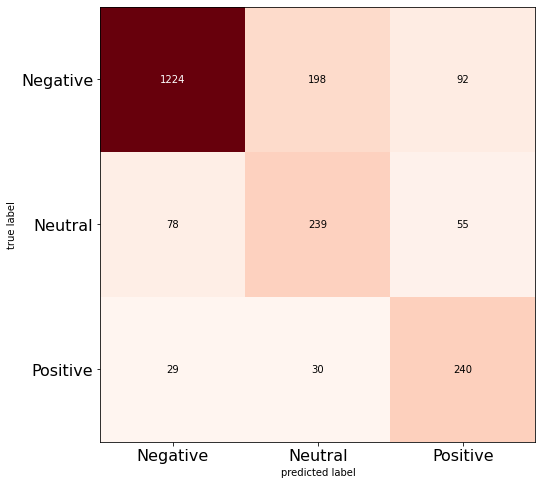

In [51]:
cm=confusion_matrix(y_validation_predict_tf_idf , y_validation_tf_idf)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
plt.show()

# Test Accuracy

In [52]:
print("Test accuracy",randomforestclassifier_tf_idf.score(x_test_main_tf_idf, y_test_main_tf_idf))
print()

Test accuracy 0.7785910338517841



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


# Classification Report (Test Set)

In [53]:
# Make class predictions for the test set
y_test_predict_tf_idf= randomforestclassifier_tf_idf.predict(x_test_main_tf_idf)
print(metrics.classification_report(y_test_main_tf_idf,y_test_predict_tf_idf))

              precision    recall  f1-score   support

    negative       0.82      0.92      0.87      1387
     neutral       0.63      0.49      0.55       465
    positive       0.74      0.60      0.66       334

    accuracy                           0.78      2186
   macro avg       0.73      0.67      0.69      2186
weighted avg       0.77      0.78      0.77      2186



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


# Confusion Matrix (Test Set)

<Figure size 720x576 with 0 Axes>

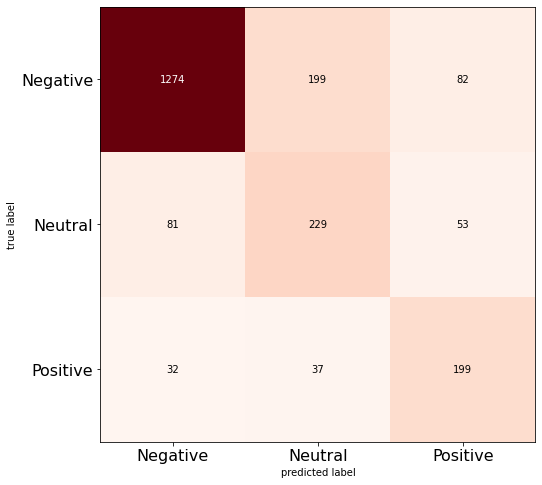

In [54]:
cm=confusion_matrix(y_test_predict_tf_idf , y_test_main_tf_idf)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
plt.show()

# CountVectorizer

In [55]:
print ("Creating the bag of words...\n")
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
count_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
count_vectorizer_data_features = count_vectorizer.fit_transform(clean_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
count_vectorizer_data_features = count_vectorizer_data_features.toarray()

Creating the bag of words...



In [56]:
print (count_vectorizer_data_features.shape)
print(count_vectorizer_data_features)

(14568, 5000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [57]:
# Take a look at the words in the vocabulary
count_vectorizer_vocab = count_vectorizer.get_feature_names()
print (count_vectorizer_vocab)

['aa', 'aacom', 'aadv', 'aadvantage', 'aafail', 'aal', 'aano', 'aarp', 'abandon', 'abc', 'abcnetwork', 'abilities', 'ability', 'able', 'aboard', 'about', 'above', 'abq', 'abroad', 'absolute', 'absolutely', 'absurd', 'abuse', 'abysmal', 'ac', 'accept', 'acceptable', 'access', 'accident', 'accidentally', 'accommodate', 'accommodations', 'accomplish', 'accord', 'accordingly', 'account', 'accountability', 'accrue', 'accts', 'accurate', 'accuse', 'achieve', 'acknowledge', 'acknowledgement', 'acknowledgment', 'acquire', 'acquisition', 'across', 'act', 'action', 'activate', 'active', 'activities', 'activitiesprevention', 'activity', 'actual', 'actually', 'actualy', 'acu', 'ad', 'adam', 'add', 'addition', 'additional', 'address', 'addtl', 'adjacent', 'admiral', 'admirals', 'admit', 'adopt', 'adore', 'ads', 'adult', 'advance', 'advantage', 'advertise', 'advice', 'advise', 'advisories', 'advisory', 'aerojobmarket', 'affect', 'affiliate', 'afford', 'affordable', 'afraid', 'after', 'afterall', 'af

C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [58]:
count_vectorizer_stop_words = count_vectorizer.get_stop_words()
print (count_vectorizer_stop_words)
# There are no stop words since we are doing sentiment analysis

None


In [59]:
# Sum up the counts of each vocabulary word
dist = np.sum(count_vectorizer_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(count_vectorizer_vocab, dist):
    print (count, tag)

274 aa
3 aacom
2 aadv
10 aadvantage
2 aafail
2 aal
2 aano
3 aarp
3 abandon
8 abc
3 abcnetwork
2 abilities
5 ability
119 able
4 aboard
516 about
18 above
9 abq
2 abroad
22 absolute
30 absolutely
13 absurd
3 abuse
6 abysmal
9 ac
32 accept
23 acceptable
39 access
5 accident
4 accidentally
26 accommodate
8 accommodations
4 accomplish
11 accord
4 accordingly
91 account
6 accountability
2 accrue
2 accts
10 accurate
2 accuse
3 achieve
4 acknowledge
2 acknowledgement
2 acknowledgment
2 acquire
2 acquisition
16 across
18 act
13 action
2 activate
4 active
1 activities
2 activitiesprevention
1 activity
21 actual
86 actually
1 actualy
1 acu
4 ad
2 adam
126 add
4 addition
17 additional
52 address
3 addtl
2 adjacent
5 admiral
12 admirals
6 admit
6 adopt
2 adore
5 ads
2 adult
14 advance
15 advantage
11 advertise
9 advice
20 advise
2 advisories
24 advisory
2 aerojobmarket
15 affect
3 affiliate
13 afford
3 affordable
2 afraid
467 after
2 afterall
30 afternoon
391 again
6 against
15 age
6 agency
258 age

9 ind
7 indeed
2 india
4 indianapolis
8 indicate
3 indication
3 individual
9 industry
5 indy
2 inefficiency
4 inefficient
3 inept
3 inevitable
7 inexcusable
15 infant
2 infants
3 inferior
35 inflight
143 info
21 inform
54 information
2 informative
2 infuriate
3 ing
9 initial
2 injure
5 injury
4 innovation
2 inop
3 input
5 inquire
2 ins
13 insane
2 insanity
18 inside
2 insight
4 insist
2 inspect
9 inspire
2 instagram
2 instal
99 instead
3 instruct
2 instructions
3 instrument
3 insufficient
13 insult
11 int
2 intact
3 integrate
4 integration
2 intelligent
4 intend
2 intent
3 intention
4 intentionally
4 interaction
3 intercom
21 interest
2 interfere
2 interior
3 intern
4 internal
55 international
3 internationally
18 internet
2 internjohnradio
13 interview
17 intl
163 into
2 intro
3 invalid
2 invest
4 investigate
2 investor
2 investors
5 invite
2 invoice
7 involve
6 ios
2 iowa
14 ipad
15 iphone
2 ireland
3 irresponsible
9 irritate
2 irrops
3 isis
3 island
2 isp
289 issue
2398 it
4 italy
1

2 surf
2 surgeries
8 surgery
2 surly
29 surprise
2 surround
7 survey
3 survive
2 susan
3 suspect
24 svc
48 sw
53 swa
2 swaculture
3 swadiversity
2 swag
2 swamp
4 swap
2 swear
2 sweepstakes
16 sweet
2 sweetheart
3 sweetingr
2 swell
2 swiss
65 switch
2 swu
6 sxm
4 sydney
2 sylvie
3 sympathetic
5 sympathy
2 sync
2 syr
3 syracuse
2 sys
144 system
17 systems
3 systemwide
3 ta
4 tab
7 table
7 tablet
29 tag
6 tail
2 tailwind
2 taiwan
510 take
25 takeoff
136 talk
2 tamara
2 tammy
16 tampa
2 tank
2 tap
3 target
84 tarmac
2 tarmack
3 taste
3 tatianaking
4 tax
16 taxi
3 taxis
3 taylor
3 tb
2 tcf
2 tcoaceboelpa
2 tcoaneqxzrbp
1 tcoapyzlsquu
4 tcoaqjnhwnac
1 tcoaqzwecokk
1 tcoarvaylmfc
1 tcoasuwxkv
1 tcoaswqwufz
1 tcoasyqetdjp
1 tcoatdsmhf
1 tcoateafncr
1 tcoatfrkpgoy
1 tcoatwyifhzy
1 tcoaucsykfuhd
1 tcoaufmxdaj
1 tcoaugjscmolu
1 tcoaurnpwd
1 tcoavbdstjujs
1 tcoavrffhmcv
1 tcoavrtowtyzk
1 tcoavyqdmpiy
1 tcoawgjkjiiac
1 tcoaxpnxiqb
1 tcoaxryeiwzh
1 tcoaycflalxv
1 tcoaygaoebuu
1 tcoaygidcfa
1 tcoayos

In [60]:
x = count_vectorizer_data_features     # Predictor feature columns
y = tweet2['airline_sentiment']   # Predicted class

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)  # 1 is just any random seed number

In [61]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10197, 5000)
(10197,)
(4371, 5000)
(4371,)


In [62]:
smt = SMOTE(random_state=0)
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(x_train, y_train)

In [63]:
print(X_train_SMOTE.shape)
print(y_train_SMOTE.shape)

(19266, 5000)
(19266,)


In [64]:
y_train_SMOTE

0        negative
1        negative
2        positive
3        negative
4        negative
           ...   
19261    positive
19262    positive
19263    positive
19264    positive
19265    positive
Name: airline_sentiment, Length: 19266, dtype: object

negative    6422
positive    6422
neutral     6422
Name: airline_sentiment, dtype: int64


C:\Users\Owner\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


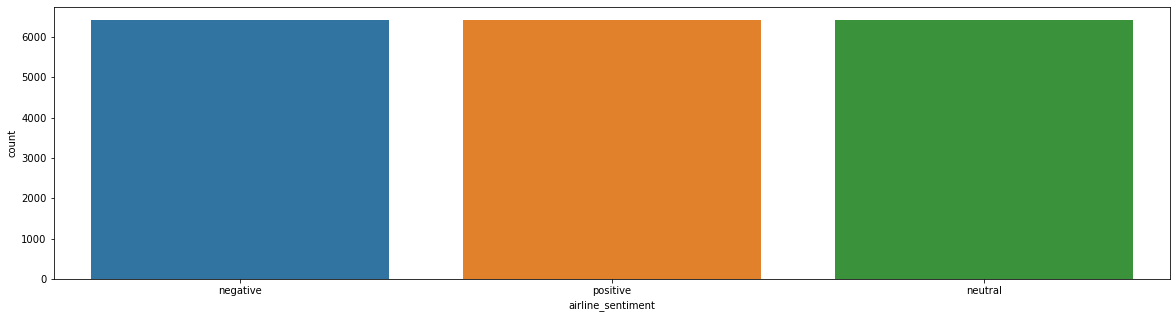

In [65]:
after_smote_airline_sentiment=pd.DataFrame(y_train_SMOTE, columns=['airline_sentiment']) 
y = after_smote_airline_sentiment['airline_sentiment']
print(y.value_counts())
plt.figure(figsize=(20,5)) 
g = sns.countplot(y)
# Here we can see that after applying smote, the data is balanced

In [66]:
# Dividing the test data into test and validation set in 50-50 ratio
x_validation, x_test_main, y_validation, y_test_main = train_test_split(x_test, y_test, test_size=0.50, random_state=1)

print(x_validation.shape)
print(x_test_main.shape)


print(y_validation.shape)
print(y_test_main.shape)

# There are 2185 samples for validation and 2186 samples for testing

(2185, 5000)
(2186, 5000)
(2185,)
(2186,)


In [67]:
# Initialize a Random Forest classifier with 100 trees
randomforestclassifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False) 
# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable

print ("Training the random forest...")
randomforestclassifier = randomforestclassifier.fit( X_train_SMOTE, y_train_SMOTE)

Training the random forest...


In [68]:
randomforestclassifier.score(X_train_SMOTE, y_train_SMOTE)

0.9340807640402782

# Evaluate score by cross-validation

In [69]:
print (np.mean(cross_val_score(randomforestclassifier,X_train_SMOTE, y_train_SMOTE,cv=10)))

0.7976342093904136


In [70]:
# Make class predictions for the Validation set
y_validation_predict= randomforestclassifier.predict(x_validation)

# Training and Validation Accuracy

In [71]:
print("Trainig accuracy",randomforestclassifier.score(X_train_SMOTE,y_train_SMOTE))  
print()
print("Validation accuracy",randomforestclassifier.score(x_validation, y_validation))
print()

Trainig accuracy 0.9340807640402782

Validation accuracy 0.7615560640732265



# Classification Report (Validation Set)

In [72]:
print(metrics.classification_report(y_validation,y_validation_predict))

              precision    recall  f1-score   support

    negative       0.81      0.90      0.85      1331
     neutral       0.60      0.51      0.55       467
    positive       0.74      0.60      0.66       387

    accuracy                           0.76      2185
   macro avg       0.71      0.67      0.69      2185
weighted avg       0.75      0.76      0.75      2185



# Confusion Matrix (Validation Set)

<Figure size 720x576 with 0 Axes>

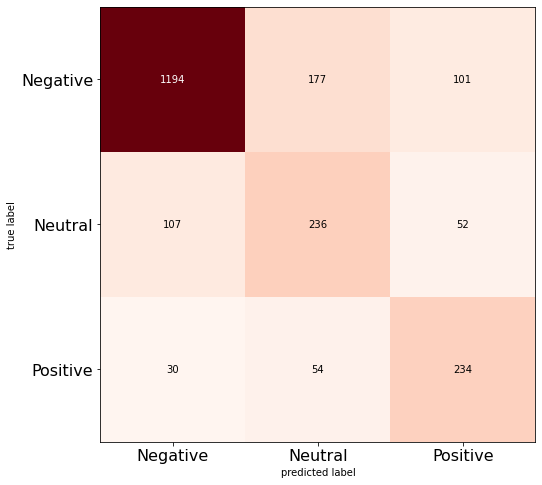

In [74]:
cm=confusion_matrix(y_validation_predict , y_validation)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
plt.show()

# Testing Data Accuracy

In [75]:
print("Testing accuracy",randomforestclassifier.score(x_test_main, y_test_main))
print()

Testing accuracy 0.7593778591033852



# Classification Report (Test Set)

In [76]:
# Make class predictions for the Validation set
y_test_predict= randomforestclassifier.predict(x_test_main)

print(metrics.classification_report(y_test_main,y_test_predict))

              precision    recall  f1-score   support

    negative       0.82      0.89      0.85      1387
     neutral       0.61      0.49      0.54       465
    positive       0.64      0.60      0.62       334

    accuracy                           0.76      2186
   macro avg       0.69      0.66      0.67      2186
weighted avg       0.75      0.76      0.75      2186



# Confusion Matrix (Test Set)

<Figure size 720x576 with 0 Axes>

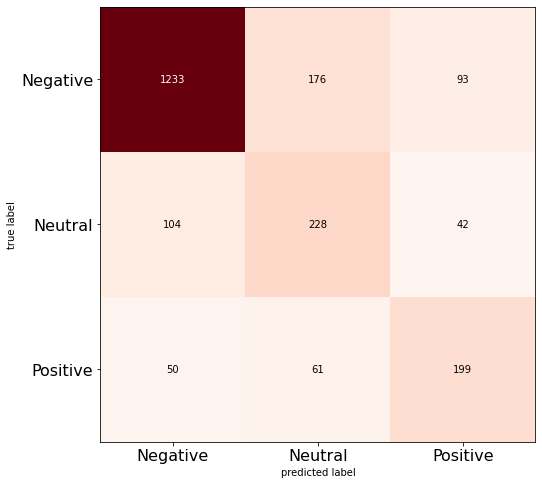

In [78]:
cm=confusion_matrix(y_test_predict , y_test_main)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
plt.show()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


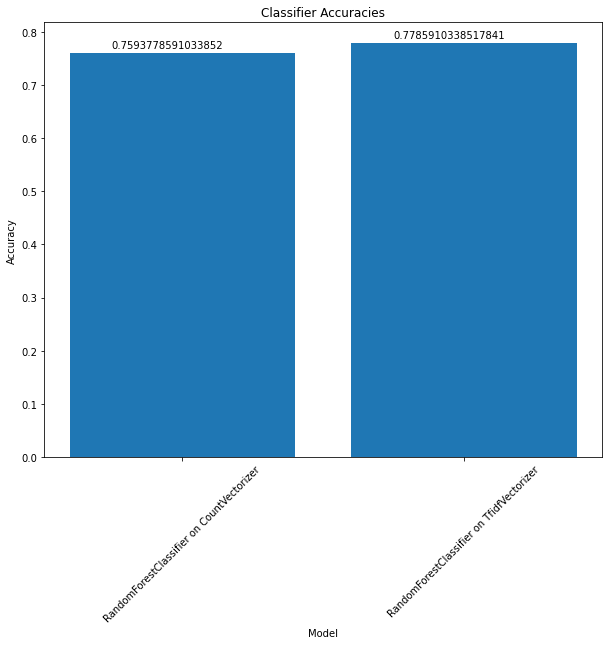

In [85]:
Accuracy=[]
Model=[]
Accuracy.append(randomforestclassifier.score(x_test_main, y_test_main))
Accuracy.append(randomforestclassifier_tf_idf.score(x_test_main_tf_idf, y_test_main_tf_idf))
Model.append("RandomForestClassifier on CountVectorizer")
Model.append("RandomForestClassifier on TfidfVectorizer")


index=[0,1]
plt.bar(index,Accuracy)
plt.xticks(index,Model,rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Classifier Accuracies')

xlocs, xlabs = plt.xticks()

for i, v in enumerate(Accuracy):
    plt.text(xlocs[i] - 0.25, v + 0.01, str(v))

# The RandomForestClassfier on TfidfVectorizer is having better accuracy

# SUMMARY

1. RandomForestClassifier on TfidfVectorizer has an accuracy of 77% whereas RandomForestClassifier on CountVectorizer has an accuracy of 75%. This shows that the model using TfidfVectorizer is better.
2. Model is able to predict airline sentiment correctly 77% of the time.
3. The dataset contains are 14668 rows and 15 columns.
4. 36 duplicate records in the data set were removed.
5. Negative sentiment was about 63 % of total sentiments in the dataset follwed by neutral at 21% and positive at 16%
6. United Airlines has the most negative tweets at 2633, follwed by US Airways at 2263 and then American at 1922
7. Customer service and Late flight seems to be the main reason why customers.
8. Most of tweets on US Airways were negative whiles most of the tweets on Virgin Atlantic were about evenly distributed between positive, netral and negative.

